# Hump Day Break: Public Sentiment on a Midweek Pause

> **Should we get Wednesdays off?**  
> Redditors have thoughts thus let's mine them!

This fun little NLP project dives into public sentiment around the idea of a 4-day work week with **Wednesdays off** instead of the usual Friday or Monday. Using over **1100 comments** from a Reddit thread, let's explore the:

- Cleaning and preprocessing comment text
- Handling tricky bits like **negation** and **lemmatization**
- Token analysis, frequency patterns, and top comment insights
- Sentiment scoring using rule-based models

The goal? Not just to clean text, but to understand what the internet really thinks about a midweek break.  
Spoiler: the vibes are surprisingly divided.

Let’s dive into the comments and see who’s really team #MidweekReset

---

## 1. Load the Data

---
### About the Dataset

This dataset contains **1127 Reddit comments** from a post in [r/unpopularopinion](https://www.reddit.com/r/unpopularopinion) discussing the idea of a 4-day work week with **Wednesdays off**.

Each comment includes the following fields:
- `comment_id`, `parent_id`: unique identifiers for Reddit threading
- `author`: Reddit username (anonymized here)
- `score`: upvotes the comment received
- `body`: the full comment text
- `created_utc`: timestamp of the comment
- `depth`: how deep the comment is in the thread
- `permalink`: direct link to the comment

> **Note**: This dataset was collected using Reddit’s public API (via Python), and no private user data was accessed.

In [1]:
# Import the libraries
import pandas as pd
import nltk
import re # For regular expressions
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from nltk.util import ngrams
from wordcloud import WordCloud

In [2]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# Load the CSV file
df = pd.read_csv("work_week.csv")

# Preview the first few rows
df.head()

,comment_id,parent_id,author,score,body,created_utc,depth,permalink
0,n3bukwv,t3_1m0t58w,AutoModerator,1,"Please remember what subreddit you are in, thi...",1.752612e+09,0,https://www.reddit.com/r/unpopularopinion/comm...
1,n3bwbdo,t3_1m0t58w,youchasechickens,5086,"Upvote, I just recently lost my 3 day weekends...",1.752612e+09,0,https://www.reddit.com/r/unpopularopinion/comm...
2,n3byyoj,t3_1m0t58w,hezthebest,827,I did 4-10s with Wednesdays off for a few year...,1.752613e+09,0,https://www.reddit.com/r/unpopularopinion/comm...
3,n3bv80p,t3_1m0t58w,sunnysam306,1344,Extra liked because 3 day weekends are amazing,1.752612e+09,0,https://www.reddit.com/r/unpopularopinion/comm...
4,n3by29p,t3_1m0t58w,SkullLeader,739,"I disagree. Yea, a 3 day weekend is too short...",1.752613e+09,0,https://www.reddit.com/r/unpopularopinion/comm...


---

## 2. Preprocess the data

---
### 2.1 Basic Text Cleaning

This step applies the following transformations to raw comment text:
- Converts all text to lowercase
- Removes URLs and hyperlinks
- Removes mentions and markdown-style links
- Strips out punctuation, numbers, and special characters
- Cleans up extra whitespace

In [4]:
# Keep only relevant columns initially
df = df[['permalink', 'score', 'body']]

# Define text cleaning function
def clean_text_basic(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www.\S+', '', text)          # Remove URLs
    text = re.sub(r'@\w+', '', text)                     # Remove mentions
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)           # Remove markdown links
    text = re.sub(r'[^a-z0-9\s]', '', text)              # Keep only letters
    text = re.sub(r'\s+', ' ', text).strip()             # Clean extra spaces
    return text

# Apply to a new column
df['clean_text'] = df['body'].apply(clean_text_basic)

# Preview a few examples
df[['score', 'body', 'clean_text']].sort_values(by='score', ascending=False).head()

,score,body,clean_text
1,5086,"Upvote, I just recently lost my 3 day weekends...",upvote i just recently lost my 3 day weekends ...
831,1482,"I loved my three day weekends! Errand day, day...",i loved my three day weekends errand day day o...
3,1344,Extra liked because 3 day weekends are amazing,extra liked because 3 day weekends are amazing
2,827,I did 4-10s with Wednesdays off for a few year...,i did 410s with wednesdays off for a few years...
4,739,"I disagree. Yea, a 3 day weekend is too short...",i disagree yea a 3 day weekend is too short bu...


---
### 2.2 Tokenization (Pre-Stopword)

This step splits the cleaned comment text into individual words using NLTK’s `word_tokenize`.
At this point, stopwords were **not** removed yet. Just tokenize to prepare for downstream steps.

In [5]:
# Prepare stopwords  
stop_words = set(stopwords.words('english'))

# Initial Tokenization (no stopword removal yet) 
# This is a simple tokenization, before any stopword removal.
def initial_tokenize(text):
    return word_tokenize(text)

df['initial_tokens'] = df['clean_text'].apply(initial_tokenize)

---
### 2.3 Negation Handling

To preserve meaning in sentences like “not helpful,” we:
- Identify common negation words (e.g., “not”, “never”, “no”, “can't”)
- Tag the next few tokens after a negation word (e.g., “not_good”, “not_useful”)
- This allows the model to distinguish negated phrases from positive ones

In [6]:
# Negation Handling Function (applied to initial_tokens) 
def handle_negation(tokens):
    # Expand negation words list 
    negation_words = {"not", "no", "never", "n't", "cannot", "don't", "aren't", "isn't", "wasn't", "weren't", "couldn't", "wouldn't", "shouldn't", "wont", "cant"}
    result = []
    negate = 0
    punctuation_to_stop_negation = {'.', ',', '!', '?', ';', ':'}

    for token in tokens:
        if token in punctuation_to_stop_negation:
            negate = 0 # Reset negation on punctuation
            result.append(token) # Keep punctuation if desired, or skip with 'continue'
            continue

        if token in negation_words:
            negate = 3 # tag next 3 words after negation word
            continue
        if negate > 0:
            result.append("not_" + token)
            negate -= 1
        else:
            result.append(token)
    return result

df['tokens_neg'] = df['initial_tokens'].apply(handle_negation)

---
### 2.4 Stopword Removal

Now that negations are handled, let's:
- Remove common English stopwords (e.g., “the”, “is”, “and”)
- Skip any stopwords that were negation-tagged (e.g., keep “not_work”)

In [7]:
# Stop Word Removal
def remove_stopwords_after_negation(tokens):
    # Only remove if the token is NOT a negation-tagged word and IS in stop_words
    # Keep words that were negated (e.g., 'not_happy')
    filtered_tokens = [w for w in tokens if not (w in stop_words and not w.startswith('not_'))]
    return filtered_tokens

df['tokens_filtered'] = df['tokens_neg'].apply(remove_stopwords_after_negation)

---
### 2.5 Lemmatization with POS Tags

Lemmatization reduces words to their base form (e.g., “working” → “work”).

Use:
- Part-of-Speech (POS) tagging to identify the correct grammatical role
- NLTK’s `WordNetLemmatizer` to return accurate lemmas

In [8]:
# Initialize Lemmatizer 
lemmatizer = WordNetLemmatizer()

# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN # Default to noun

# Combine POS tagging and Lemmatization Function
def pos_tag_and_lemmatize(tokens_final):
    # Perform POS tagging on the tokens after filtering and negation
    tagged_tokens = nltk.pos_tag(tokens_final)
    lemmatized_words = []
    for word, tag in tagged_tokens:
        w_pos = get_wordnet_pos(tag)
        lemmatized_words.append(lemmatizer.lemmatize(word, pos=w_pos))
    return lemmatized_words

# Apply the combined function to 'tokens_filtered' column
df['lemmatized_final'] = df['tokens_filtered'].apply(pos_tag_and_lemmatize)

# Preview the final result 
print(df[['score', 'clean_text', 'lemmatized_final']].sort_values(by='score', ascending=False).head())

     score                                         clean_text  \
1     5086  upvote i just recently lost my 3 day weekends ...   
831   1482  i loved my three day weekends errand day day o...   
3     1344     extra liked because 3 day weekends are amazing   
2      827  i did 410s with wednesdays off for a few years...   
4      739  i disagree yea a 3 day weekend is too short bu...   

                                      lemmatized_final  
1    [upvote, recently, lose, 3, day, weekend, miss...  
831  [loved, three, day, weekend, errand, day, day,...  
3                [extra, like, 3, day, weekend, amaze]  
2    [410s, wednesday, year, amaze, didnt, feel, li...  
4    [disagree, yea, 3, day, weekend, short, id, ra...  


---

## 3. Sentiment Scoring

The **VADER SentimentIntensityAnalyzer** is a lexicon and rule-based sentiment analysis tool tuned for social media text.

In [9]:
# Initialize VADER Analyzer
analyzer = SentimentIntensityAnalyzer()

In [10]:
# Apply VADER's polarity_scores to the 'clean_text' column
df['sentiment_scores'] = df['clean_text'].apply(analyzer.polarity_scores)

# Extract the 'compound' score, which is a normalized weighted composite score.
df['compound_score'] = df['sentiment_scores'].apply(lambda x: x['compound'])

In [11]:
# Define a function to classify sentiment based on the compound score
def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the classification function to create the 'sentiment' column
df['sentiment'] = df['compound_score'].apply(classify_sentiment)

In [12]:
# Display comments with their clean text, compound score, and classified sentiment
print(df[['body', 'clean_text', 'compound_score', 'sentiment']].head())

# To see a distribution of sentiments:
print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())

# To see top positive and negative comments
print("\nTop 5 Most Positive Comments:")
print(df.sort_values(by='compound_score', ascending=False)[['clean_text', 'compound_score']].head())

print("\nTop 5 Most Negative Comments:")
print(df.sort_values(by='compound_score', ascending=True)[['clean_text', 'compound_score']].head())

                                                body  \
0  Please remember what subreddit you are in, thi...   
1  Upvote, I just recently lost my 3 day weekends...   
2  I did 4-10s with Wednesdays off for a few year...   
3     Extra liked because 3 day weekends are amazing   
4  I disagree.  Yea, a 3 day weekend is too short...   

                                          clean_text  compound_score sentiment  
0  please remember what subreddit you are in this...         -0.1027  Negative  
1  upvote i just recently lost my 3 day weekends ...          0.3400  Positive  
2  i did 410s with wednesdays off for a few years...          0.8121  Positive  
3     extra liked because 3 day weekends are amazing          0.7650  Positive  
4  i disagree yea a 3 day weekend is too short bu...         -0.7814  Negative  

Sentiment Distribution:
sentiment
Positive    725
Negative    229
Neutral     173
Name: count, dtype: int64

Top 5 Most Positive Comments:
                                     

---
## 4. Data Visualization

---
### 4.1 Sentiment by Reddit Score

**Objective**: To understand if the sentiment of comments aligns with their popularity (upvotes). 

In [13]:
# Calculate average score per sentiment
average_scores = df.groupby('sentiment')['score'].mean().sort_values(ascending=False)
print("Average Score per Sentiment:")
print(average_scores)

Average Score per Sentiment:
sentiment
Positive    16.573793
Negative     8.227074
Neutral      4.930636
Name: score, dtype: float64


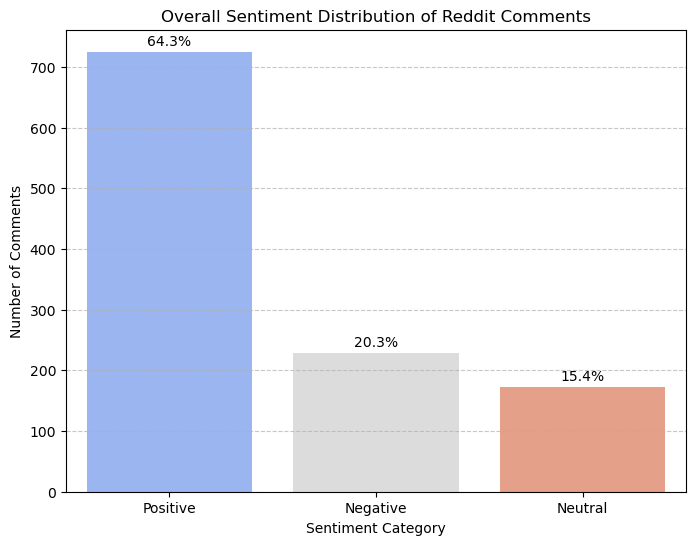

In [14]:
# Get the counts of each sentiment
sentiment_counts = df['sentiment'].value_counts()

# Calculate percentages for labeling
sentiment_percentages = df['sentiment'].value_counts(normalize=True) * 100

# Create a DataFrame for easy plotting and sorting
sentiment_df = pd.DataFrame({
    'Sentiment': sentiment_counts.index,
    'Count': sentiment_counts.values,
    'Percentage': sentiment_percentages.values
})

# Sort by count for better visualization in descending
sentiment_df = sentiment_df.sort_values(by='Count', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Sentiment', y='Count', data=sentiment_df, palette='coolwarm')
plt.title('Overall Sentiment Distribution of Reddit Comments')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Comments')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage labels on top of bars
for index, row in sentiment_df.iterrows():
    plt.text(index, row['Count'] + 10, f"{row['Percentage']:.1f}%", color='black', ha="center")

plt.show()

### Interpretation
- **Predominantly Positive**: The majority of comments (**64.3%**) are positive, indicating a generally favorable tone in the discussions.
- **Significant Minority of Negativity: 20.3%** of comments are negative, showing a notable dissenting voice.
- **Limited Neutrality**: Only **15.4%** of comments are neutral, suggesting most users express a clear emotional stance.

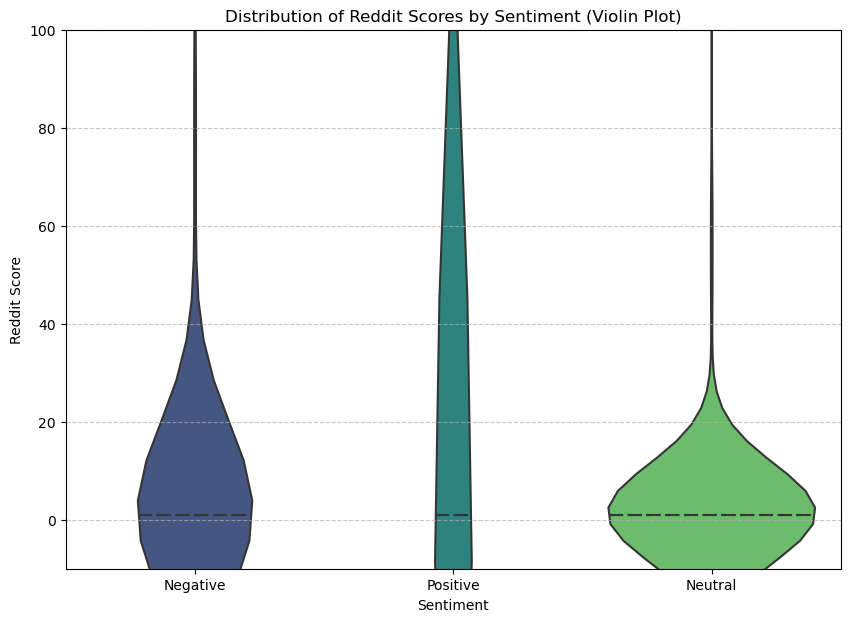

In [15]:
# Visualize score distribution per sentiment 
plt.figure(figsize=(10, 7))
sns.violinplot(x='sentiment', y='score', data=df, palette='viridis', inner='quartile') # 'inner' can show quartiles
plt.title('Distribution of Reddit Scores by Sentiment (Violin Plot)')
plt.xlabel('Sentiment')
plt.ylabel('Reddit Score')
plt.ylim(-10, 100) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Interpretation 

* **Overwhelming Concentration at Score 1:** The widest part of each violin is heavily concentrated around a Reddit score of **1**, indicating that most comments, regardless of sentiment, receive minimal engagement.
* **Presence of High Outliers:** Long, thin tails extending upwards signify a few **highly popular comments** with much higher scores, appearing across all sentiment types.
* **Polarized Engagement:** Both positive and negative sentiments can achieve high scores, suggesting a **polarized yet highly engaged discussion** where diverse opinions gain visibility.

---
### 4.2 Keyword Analysis by Sentiment

**Objective**: To identify the specific words and phrases (n-grams) that are most characteristic of each sentiment category.

In [16]:
# Separate comments by sentiment
positive_comments_lemmatized = df[df['sentiment'] == 'Positive']['lemmatized_final']
negative_comments_lemmatized = df[df['sentiment'] == 'Negative']['lemmatized_final']
neutral_comments_lemmatized = df[df['sentiment'] == 'Neutral']['lemmatized_final']

In [17]:
# Prepare text for WordCloud and bigrams
def prepare_text_for_wordcloud(comment_series, include_bigrams=True, top_bigrams_to_include=100):
    all_tokens = [token for sublist in comment_series for token in sublist if token not in ['.', ',', '!', '?', ';', ':']] # Filter punctuation

    text_for_cloud = all_tokens # Start with unigrams

    if include_bigrams:
        # Generate all bigrams
        all_bigrams = list(ngrams(all_tokens, 2))
        
        # Count bigram frequencies
        bigram_frequencies = Counter(all_bigrams)
        
        # Select a certain number of the most common bigrams
        common_bigrams = bigram_frequencies.most_common(top_bigrams_to_include)
        
        # Format bigrams as "word1_word2" and add them to the text
        formatted_bigrams = ["_".join(bg) for bg, count in common_bigrams]
        text_for_cloud.extend(formatted_bigrams)
        
    return " ".join(text_for_cloud)

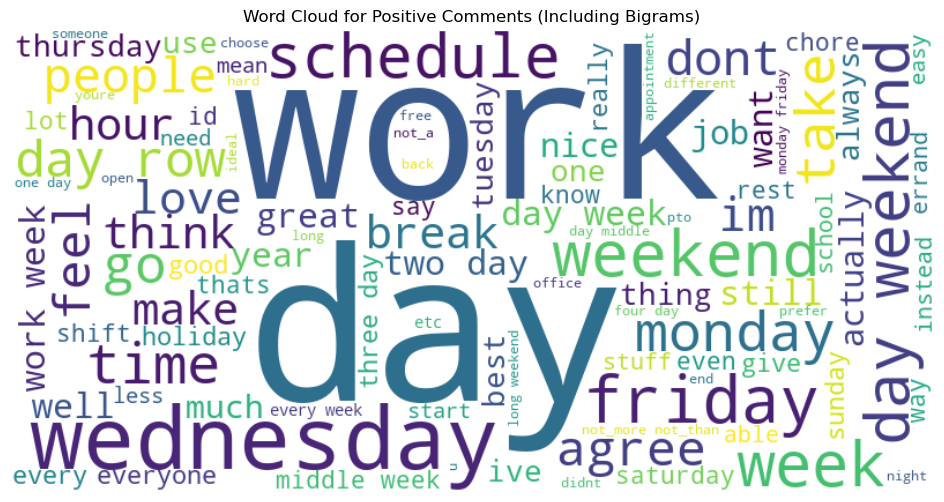

In [18]:
# Generate and display Word Clouds

# Positive Comments Word Cloud
positive_text_cloud = prepare_text_for_wordcloud(positive_comments_lemmatized)
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=100).generate(positive_text_cloud)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Comments (Including Bigrams)')
plt.show()

### Interpretation 
* **Core Focus:** Dominant terms like "**work**," "**day**," "**wednesday**," and "**weekend**" confirm the discussion centers on work week structure.
* **Strong Support for Flexibility:** Words like "**love**," "**agree**," and "**feel**" indicate a positive and emotional connection to the idea.
* **Mid-Week Break Benefits:** "**Break**," "**time**," and "**appointment**" highlight the perceived advantages of mid-week pauses for rest and errands.
* **Work Week Comparison:** Mentions of other days suggest users are comparing different schedule models.

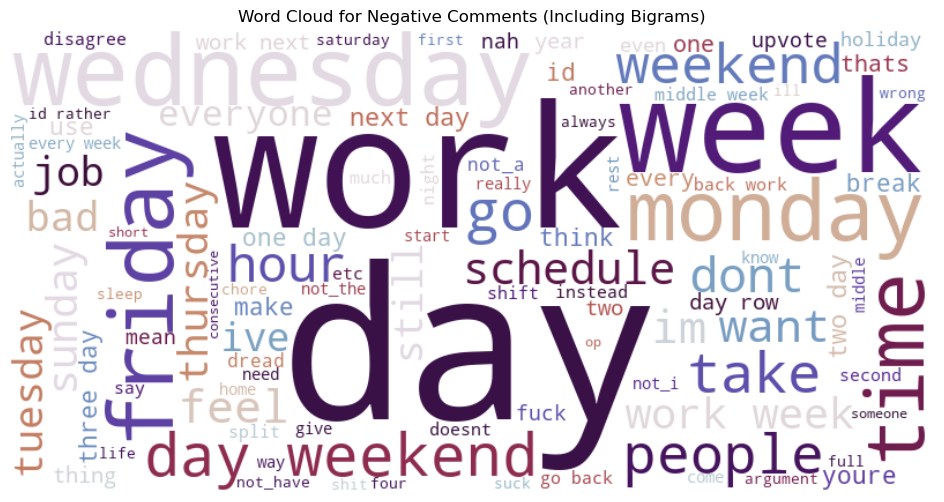

In [19]:
# Negative Comments Word Cloud
negative_text_cloud = prepare_text_for_wordcloud(negative_comments_lemmatized)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white', colormap='twilight_r', max_words=100).generate(negative_text_cloud) # Different colormap for contrast

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Comments (Including Bigrams)')
plt.show()

### Interpretation 

* **Focus on Disruption:** Dominant terms like "**work**," "**day**," "**week**," "**wednesday**," and "**schedule**" confirm the core topic, but with a focus on **logistical concerns and routine disruption**.
* **Clear Resistance:** Words such as "**dont**," "**disagree**," "**wrong**," "**fuck**," and "**dread**" highlight a **strong tone of resistance and frustration** towards the idea.
* **Preference for Consecutive Work/Rest:** Phrases like "**split**," "**middle**," "**consecutive**," and "**back\_to\_work**" suggest dissatisfaction with breaking the work rhythm mid-week, indicating a preference for continuous workdays followed by longer, uninterrupted rest.
* **Alternate Schedule Comparison:** Mentions of "**monday**," "**friday**," and "**sunday**" show users are comparing to alternate setups, likely favoring a **traditional long weekend**.